In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import scipy
from control import dare
from kalman import KalmanFilter
import constants as ct
from parameters import *
from particle3D import Particle

In [5]:
delta_t = 1e-9
control_step = int(32e-9/delta_t)
t = np.arange(0, 70 * (1/100e3), delta_t)
N = t.shape[0]
pressure = 9.2e-7
radius = 71.5e-9
wavelength = 1.064e-6
power = 300e-3
waist = 0.6352e-6 
eta_detection = 0.178
fs = 1/(control_step*delta_t)

gamma, _, ba_force, std_detection, std_z = compute_parameters_simulation(power, wavelength, waist,
                                                                      radius, pressure, fs, eta_detection)
coupling = (1/(4*np.pi))*(ba_force**2)
omegas = np.array([2*np.pi*94e3, 2*np.pi*102e3, 2*np.pi*30e3])

B = np.array([[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, 1]])
env = Particle(omegas, gamma, B, coupling, eta_detection=eta_detection, radius=radius)

variance_process_x = env.thermal_force_std_x**2 + env.backaction_std_x**2
variance_process_y = env.thermal_force_std_y**2 + env.backaction_std_y**2
variance_process_z = env.thermal_force_std_z**2 + env.backaction_std_z**2
Q = np.array([[0, 0, 0, 0, 0, 0], 
            [0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0],
            [0, 0, 0, variance_process_x, 0, 0],
            [0, 0, 0, 0, variance_process_y, 0],
            [0, 0, 0, 0, 0, variance_process_z]])*control_step*delta_t/2
R = np.array([[3*np.power(std_detection/env.zp_x, 2), 0, 0],
            [0, 6*np.power(std_detection/env.zp_y, 2), 0],
            [0, 0, np.power(std_detection/env.zp_z, 2)]])

g_fb = 100
Ad = scipy.linalg.expm(env.A *control_step*delta_t)
Bd = env.B * delta_t * control_step
cost_states = np.array([[omegas[0]/2, 0, 0, 0, 0, 0],
                        [0, omegas[1]/2, 0, 0, 0, 0],
                        [0, 0, omegas[2]/2, 0, 0, 0],
                        [0, 0, 0, omegas[0]/2, 0, 0],
                        [0, 0, 0, 0, omegas[1]/2, 0],
                        [0, 0, 0, 0, 0, omegas[2]/2]])
control_effort = np.array([[1/(2*omegas[0]), 0, 0],
                        [0, 1/(2*omegas[1]), 0],
                        [0, 0, 1/(2*omegas[2])]])
X, L, G = dare(Ad, Bd, cost_states, control_effort/(g_fb))
G

array([[ 4.71108735e+06, -7.31456615e-05, -2.75622343e-09,
         5.88510226e+06, -7.31521340e-05, -2.34919372e-10],
       [-6.31938762e-05,  5.05705559e+06,  5.22123808e-03,
        -7.89418881e-05,  6.33918225e+06,  4.45740054e-04],
       [-5.66361970e-11,  9.88307866e-05,  1.63878726e+06,
        -7.07500236e-11,  1.23887578e-04,  1.99240646e+06]])

In [6]:
x0 = 1e4
P0 = (1e4**2)*np.matrix(np.eye(6))
estimation = np.zeros((6,1))
states = x0*np.ones((6,1))
new_states = np.zeros((N, 6))
measured_states = np.zeros((N,3))
estimated_states = np.zeros((N, 6))
estimated_states[0, :] = estimation[:,0]
control=np.zeros((3,1))
controls = np.zeros((3, N))
kalman = KalmanFilter(estimation, P0, Ad, Bd, env.C, Q, R)
for i in tqdm(range(t.shape[0])):
    new_states[i, :] = states[:, 0]
    if not i % control_step:
        measurement_noise = np.array(
                [np.sqrt(3)*np.random.normal()*std_detection/env.zp_x,
                np.sqrt(6)*np.random.normal()*std_detection/env.zp_y,
                np.random.normal()*std_detection/env.zp_z]
                )
        measured_states[i,:] = env.C@states[:, 0] + measurement_noise
        kalman.propagate_dynamics(control)
        kalman.compute_aposteriori(measured_states[i].reshape((3,1)))
        estimated_states[i, :] = kalman.estimates_aposteriori[int(i/control_step)][:, 0].reshape((6))
        estimation = estimated_states[i, :].reshape((6, 1))   
        control = -G@estimation
    else:
        measured_states[i] = measured_states[i-1]
        estimated_states[i, :] = estimated_states[i-1,:]
    controls[:,i] = control[:,0]
    states = env.step(states, control=control, delta_t=delta_t)

100%|██████████| 700000/700000 [00:47<00:00, 14680.06it/s]


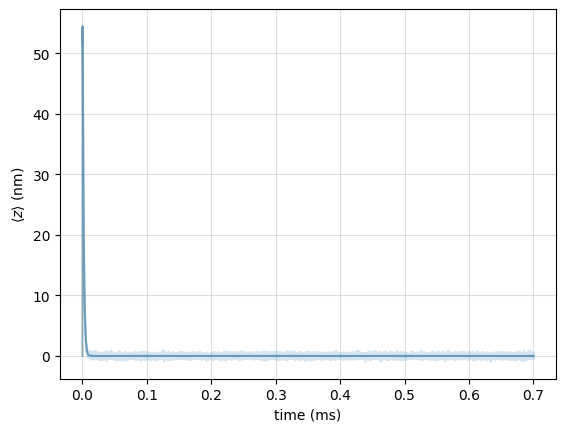

In [8]:
colors = ['#2E86C1', '#85C1E9', '#1B4F72']

plt.plot(1e3*t[::control_step],env.zp_x*1e9*measured_states[::control_step,0], color = colors[0], alpha = 0.2)
plt.plot(1e3*t[::control_step],env.zp_x*1e9*new_states[::control_step,0], color = colors[1], alpha = 0.6)
plt.plot(1e3*t[::control_step],env.zp_x*1e9*estimated_states[::control_step,0], color = colors[2], alpha = 0.4)
plt.ylabel(r'$\langle X \rangle$ (nm)')
plt.xlabel(r'time (ms)')
plt.grid(alpha = 0.4)

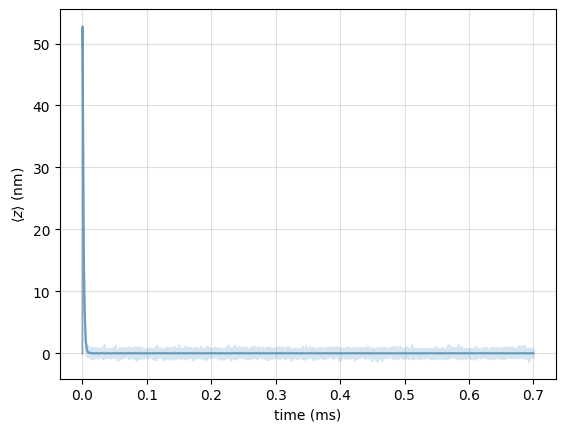

In [9]:
colors = ['#2E86C1', '#85C1E9', '#1B4F72']

plt.plot(1e3*t[::control_step],env.zp_y*1e9*measured_states[::control_step,1], color = colors[0], alpha = 0.2)
plt.plot(1e3*t[::control_step],env.zp_y*1e9*new_states[::control_step,1], color = colors[1], alpha = 0.6)
plt.plot(1e3*t[::control_step],env.zp_y*1e9*estimated_states[::control_step,1], color = colors[2], alpha = 0.4)
plt.ylabel(r'$\langle y \rangle$ (nm)')
plt.xlabel(r'time (ms)')
plt.grid(alpha = 0.4)

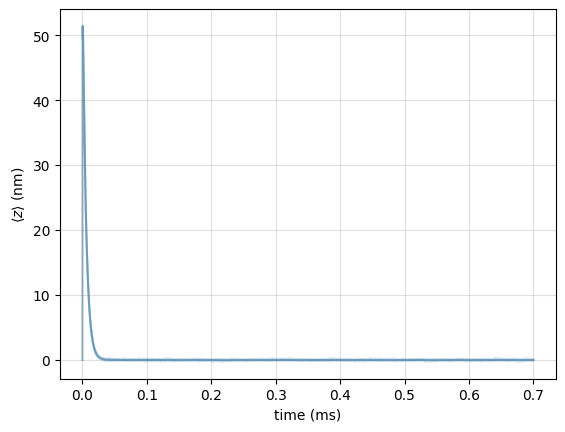

In [10]:
colors = ['#2E86C1', '#85C1E9', '#1B4F72']

plt.plot(1e3*t[::control_step],env.zp_y*1e9*measured_states[::control_step,2], color = colors[0], alpha = 0.2)
plt.plot(1e3*t[::control_step],env.zp_y*1e9*new_states[::control_step,2], color = colors[1], alpha = 0.6)
plt.plot(1e3*t[::control_step],env.zp_y*1e9*estimated_states[::control_step,2], color = colors[2], alpha = 0.4)
plt.ylabel(r'$\langle z \rangle$ (nm)')
plt.xlabel(r'time (ms)')
plt.grid(alpha = 0.4)